In [47]:
import pandas as pd
import os
from matplotlib import pyplot
from pandas_profiling import ProfileReport
import numpy as np
from datetime import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal      #PERIODOGRAMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from scipy.stats import yeojohnson
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
os.chdir('C:/Users/teresa.lendez/OneDrive - Tinamica/Documentos/00_Repositorios/LaboratorioSeriesTemporales/data')

In [3]:
df = pd.read_csv('Madrid_polution_dataframe.csv', sep = ',')

In [4]:

'''Modificaciones en el fichero'''

df['DAY'] = df['DAY'].astype(str)
df['MONTH'] = df['MONTH'].astype(str)
df['YEAR'] = df['YEAR'].astype(str)
df['HOUR'] = df['HOUR'].astype(str)
df['SEASON'] = df['SEASON'].astype(str)

df['len_day'] = df['DAY'].str.len()
df['len_month'] = df['MONTH'].str.len()

df['DAY'] = np.where(df['len_day'] == 1,'0' + df['DAY'], df['DAY'])
df['MONTH'] = np.where(df['len_month'] == 1,'0' + df['MONTH'], df['MONTH'])

df['date'] = df['DAY'] + '/' + df['MONTH'] + '/' + df['YEAR']
df['date'] = df['date'].astype(str)
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y', errors='ignore')

df['year'] = df.date.dt.year
df['month'] = df.date.dt.month

df['anyomes'] = np.where(df['date'].dt.month < 10,
                               df['date'].dt.year.apply(str) + '0' + df['date'].dt.month.apply(str),
                               df['date'].dt.year.apply(str) + df['date'].dt.month.apply(str))

df['anyosem'] = np.where(df['date'].dt.weekofyear < 10,
                               df['date'].dt.year.apply(str) + '0' + df['date'].dt.weekofyear.apply(str),
                               df['date'].dt.year.apply(str) + df['date'].dt.weekofyear.apply(str))

<ipython-input-4-1f04e8593a8b>:26: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['anyosem'] = np.where(df['date'].dt.weekofyear < 10,
<ipython-input-4-1f04e8593a8b>:27: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['date'].dt.year.apply(str) + '0' + df['date'].dt.weekofyear.apply(str),
<ipython-input-4-1f04e8593a8b>:28: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['date'].dt.year.apply(str) + df['date'].dt.weekofyear.apply(str))


In [5]:
df

,YEAR,MONTH,DAY,HOUR,SEASON,PM_RETIRO,PM_VALLECAS,PM_CIUDADLINEAL,PM_CENTRO,DEW_POINT,...,WIND_SPEED,PRECIPITAITON,COMMULATIVE_PRECIPITATION,len_day,len_month,date,year,month,anyomes,anyosem
0,2010,01,01,0,4,NaN,NaN,NaN,NaN,-21.0,...,1.79,0.0,0.0,1,1,2010-01-01,2010,1,201001,201053
1,2010,01,01,1,4,NaN,NaN,NaN,NaN,-21.0,...,4.92,0.0,0.0,1,1,2010-01-01,2010,1,201001,201053
2,2010,01,01,2,4,NaN,NaN,NaN,NaN,-21.0,...,6.71,0.0,0.0,1,1,2010-01-01,2010,1,201001,201053
3,2010,01,01,3,4,NaN,NaN,NaN,NaN,-21.0,...,9.84,0.0,0.0,1,1,2010-01-01,2010,1,201001,201053
4,2010,01,01,4,4,NaN,NaN,NaN,NaN,-20.0,...,12.97,0.0,0.0,1,1,2010-01-01,2010,1,201001,201053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52579,2015,12,31,19,4,140.0,157.0,122.0,133.0,-8.0,...,7.14,0.0,0.0,2,2,2015-12-31,2015,12,201512,201553
52580,2015,12,31,20,4,157.0,199.0,149.0,169.0,-8.0,...,8.03,0.0,0.0,2,2,2015-12-31,2015,12,201512,201553
52581,2015,12,31,21,4,171.0,231.0,196.0,203.0,-10.0,...,0.89,0.0,0.0,2,2,2015-12-31,2015,12,201512,201553
52582,2015,12,31,22,4,204.0,242.0,221.0,212.0,-10.0,...,1.78,0.0,0.0,2,2,2015-12-31,2015,12,201512,201553


In [6]:
df_final = df.copy()
df_final = df_final[df_final['date']>'01/01/2010']

In [7]:
df_final['PM_CENTRO_new'] = np.where(df_final['PM_CENTRO'].isnull(),df_final['PM_RETIRO'],df_final['PM_CENTRO'])
df_final['PM_CENTRO_new2'] = np.where(df_final['PM_CENTRO_new'].isnull(),df_final['PM_VALLECAS'],df_final['PM_CENTRO_new'])
df_final['PM_CENTRO_final'] = np.where(df_final['PM_CENTRO_new2'].isnull(),df_final['PM_CIUDADLINEAL'],df_final['PM_CENTRO_new2'])

In [8]:
df_final['PM_CENTRO_final'] =df_final['PM_CENTRO_final'].fillna(0)

### Serie Diaria

In [9]:
df_day = pd.DataFrame(df_final.groupby(['date'], as_index=False).agg({'SEASON': 'min', 'PM_RETIRO': 'mean', 
                                  'PM_VALLECAS': 'mean', 'PM_CIUDADLINEAL': 'mean', 'PM_CENTRO_final': 'mean', 
                                  'DEW_POINT': 'mean', 'HUMIDITY': 'mean', 'TEMPERATURE': 'mean','WIND_SPEED': 'mean', 
                                  'PRECIPITAITON': 'sum', 'COMMULATIVE_PRECIPITATION': 'max'}))
df_day

,date,SEASON,PM_RETIRO,PM_VALLECAS,PM_CIUDADLINEAL,PM_CENTRO_final,DEW_POINT,HUMIDITY,TEMPERATURE,WIND_SPEED,PRECIPITAITON,COMMULATIVE_PRECIPITATION
0,2010-01-02,4,NaN,NaN,NaN,144.333333,-8.500000,77.937500,3.372951,24.860000,0.0,0.0
1,2010-01-03,4,NaN,NaN,NaN,78.375000,-10.125000,87.916667,0.572404,70.937917,11.2,11.2
2,2010-01-04,4,NaN,NaN,NaN,29.291667,-20.875000,46.208333,-1.852459,111.160833,0.0,0.0
3,2010-01-05,4,NaN,NaN,NaN,43.541667,-24.583333,42.041667,-4.277322,56.920000,0.0,0.0
4,2010-01-06,4,NaN,NaN,NaN,59.375000,-23.708333,39.208333,-2.706284,18.511667,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2185,2015-12-27,4,52.791667,66.041667,57.708333,56.208333,-13.958333,53.541667,2.928962,3.950833,0.0,0.0
2186,2015-12-28,4,117.416667,119.583333,111.833333,112.416667,-11.458333,60.750000,4.056011,13.656667,0.0,0.0
2187,2015-12-29,4,323.416667,361.500000,330.750000,331.875000,-6.625000,76.125000,5.285519,1.244583,0.0,0.0
2188,2015-12-30,4,51.791667,135.500000,94.291667,101.750000,-8.750000,58.458333,7.300546,26.502500,0.0,0.0


### Serie Semanal

In [22]:
df_week = pd.DataFrame(df_final.groupby(['anyosem'], as_index=False).agg({'PM_CENTRO_final': 'mean', 
                                  'DEW_POINT': 'mean', 'HUMIDITY': 'mean', 'TEMPERATURE': 'mean','WIND_SPEED': 'mean', 
                                  'PRECIPITAITON': 'sum', 'COMMULATIVE_PRECIPITATION': 'max'}))
df_week

,anyosem,PM_CENTRO_final,DEW_POINT,HUMIDITY,TEMPERATURE,WIND_SPEED,PRECIPITAITON,COMMULATIVE_PRECIPITATION
0,201001,74.119048,-19.976190,50.678571,-1.862217,32.778571,0.0,0.0
1,201002,88.250000,-18.083333,49.750000,0.157689,43.464464,0.0,0.0
2,201003,106.773810,-14.202381,46.404762,5.017174,38.843810,0.0,0.0
3,201004,50.202381,-17.744048,29.684524,7.002927,51.740417,0.0,0.0
4,201005,76.416667,-14.017857,52.934524,3.836456,10.406071,0.0,0.0
...,...,...,...,...,...,...,...,...
309,201549,160.470238,-7.706587,59.700599,7.981152,57.305150,0.0,0.0
310,201550,172.720238,-3.577381,74.410714,8.403201,5.003631,0.0,0.0
311,201551,98.160714,-9.684524,55.404762,7.080991,77.864940,1.2,0.7
312,201552,254.404762,-6.523810,76.750000,5.539227,4.200238,0.0,0.0


### Serie Mensual

In [13]:
df_month = pd.DataFrame(df_final.groupby(['anyomes'], as_index=False).agg({'PM_CENTRO_final': 'mean', 
                                  'DEW_POINT': 'mean', 'HUMIDITY': 'mean', 'TEMPERATURE': 'mean','WIND_SPEED': 'mean', 
                                  'PRECIPITAITON': 'sum', 'COMMULATIVE_PRECIPITATION': 'max'}))
df_month

,anyomes,PM_CENTRO_final,DEW_POINT,HUMIDITY,TEMPERATURE,WIND_SPEED,PRECIPITAITON,COMMULATIVE_PRECIPITATION
0,201001,81.937500,-16.955556,46.715972,2.538479,42.119625,11.2,11.2
1,201002,97.095238,-13.156250,47.644345,5.997853,13.466786,5.2,4.7
2,201003,89.622312,-7.955645,49.841398,10.272960,23.281237,23.2,10.1
3,201004,79.850000,-3.330556,43.124306,16.431922,58.280833,19.9,11.9
4,201005,86.252688,7.651882,48.200269,24.649172,21.419126,50.3,13.9
...,...,...,...,...,...,...,...,...
67,201508,44.633065,19.452221,70.355316,28.745140,7.601992,71.2,31.8
68,201509,47.220833,14.562500,72.455556,24.301913,12.558611,76.9,20.0
69,201510,72.061828,4.784946,60.688172,18.908161,35.924113,14.4,8.1
70,201511,124.822222,-0.568846,75.958442,9.948426,13.798359,1000011.0,999990.0


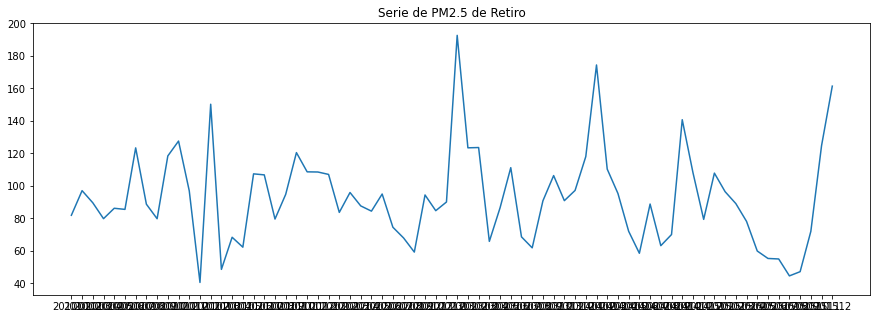

In [14]:
pyplot.figure(figsize=(15,5))
pyplot.title("Serie de PM2.5 de Retiro")
pyplot.plot(df_month.anyomes,df_month.PM_CENTRO_final)
pyplot.show()

<ipython-input-16-a8c5680d368f>:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  descomposicion_aditiva = seasonal_decompose(df_week.PM_CENTRO_final,model='additive',freq=120)


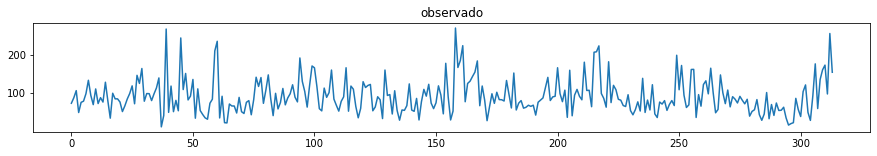

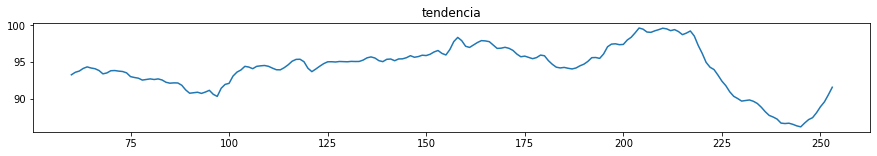

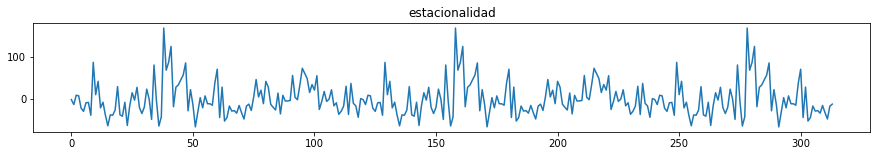

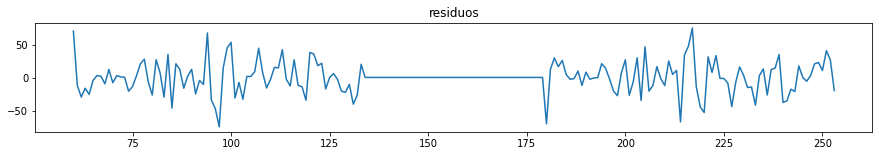

In [16]:

# descomposicion_aditiva

descomposicion_aditiva = seasonal_decompose(df_week.PM_CENTRO_final,model='additive',freq=120)
descomposicion_aditiva.observed.plot(figsize=(15,2),title='observado')
pyplot.show()
descomposicion_aditiva.trend.plot(figsize=(15,2),title='tendencia')
pyplot.show()
descomposicion_aditiva.seasonal.plot(figsize=(15,2),title='estacionalidad')
pyplot.show()
descomposicion_aditiva.resid.plot(figsize=(15,2),title='residuos')
pyplot.show()

<ipython-input-17-7c6569e2b765>:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  descomposicion_multiplicativa = seasonal_decompose(np.sqrt(df_week['PM_CENTRO_final']+50),model='multiplicative',freq=120)


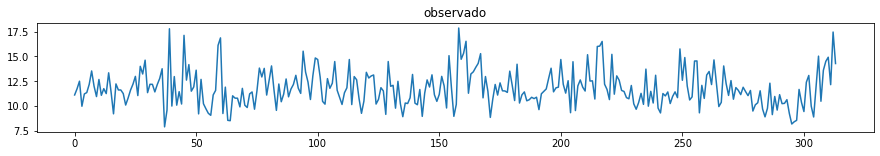

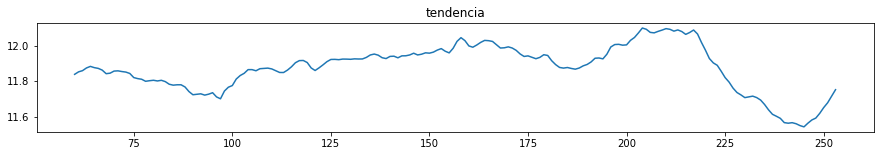

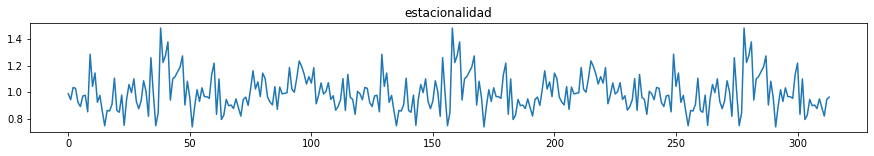

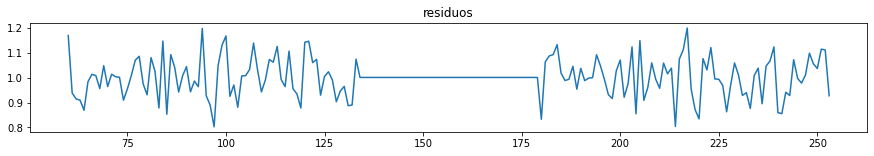

In [17]:
'''descomposicion_multiplicativa'''

descomposicion_multiplicativa = seasonal_decompose(np.sqrt(df_week['PM_CENTRO_final']+50),model='multiplicative',freq=120)
descomposicion_multiplicativa.observed.plot(figsize=(15,2),title='observado')
pyplot.show()
descomposicion_multiplicativa.trend.plot(figsize=(15,2),title='tendencia')
pyplot.show()
descomposicion_multiplicativa.seasonal.plot(figsize=(15,2),title='estacionalidad')
pyplot.show()
descomposicion_multiplicativa.resid.plot(figsize=(15,2),title='residuos')
pyplot.show()

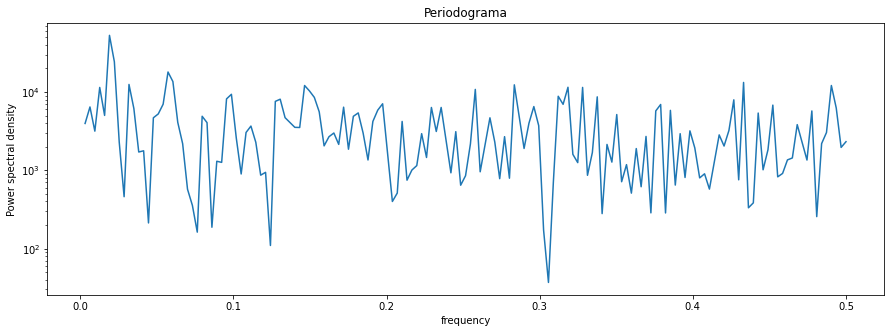

In [18]:
# Periodograma

f, Pxx_den = signal.periodogram(df_week['PM_CENTRO_final'])
pyplot.figure(figsize=(15,5))
pyplot.semilogy(f[1:10000000], Pxx_den[1:10000000])
pyplot.title('Periodograma')
pyplot.xlabel('frequency')
pyplot.ylabel('Power spectral density')
pyplot.show()

In [26]:
df_week_o = df_week.PM_CENTRO_final

In [27]:
print("p-value ADFuller (h0: serie no estacionaria en media):", adfuller(df_week_o.dropna())[1]) #¿la serie es estacionaria en media?
print("p-value KPSS (h0: serie estacionaria en media):", kpss(df_week_o.dropna())[1]) #¿la serie es estacionaria en media?

p-value ADFuller (h0: serie no estacionaria en media): 0.0001056456124228184
p-value KPSS (h0: serie estacionaria en media): 0.1


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


In [49]:
ts_week_t , lambda_t = yeojohnson(df_week_o) #¿Transformar la serie? Usar boxcox o yeojohnson
ts_week_t = pd.DataFrame(ts_week_t)
print(lambda_t)

0.19092905859746923


Este resultado, a no ser cercano a 1, probablemente necesite transformación.

Identificación inicial de la serie mediante los gráficos ACF y PACF.

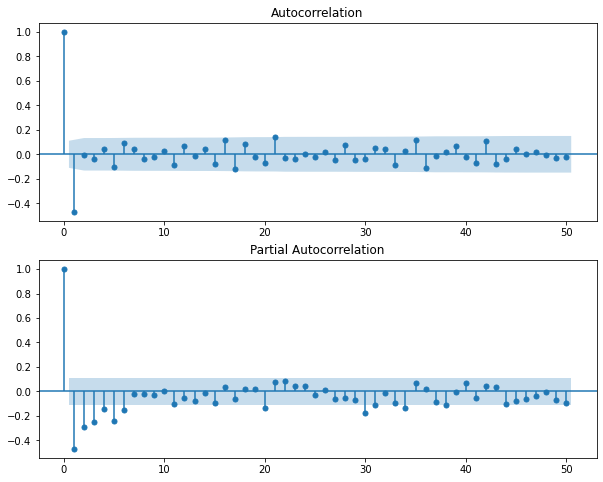

In [28]:
fig,ax = pyplot.subplots(2,1,figsize=(10,8))
fig = plot_acf(df_week_o.diff().dropna(), lags=50, ax=ax[0])
fig = plot_pacf(df_week_o.diff().dropna(), lags=50, ax=ax[1])
pyplot.show()

##### Ajuste del modelo ARIMA sin covariables 

In [34]:
model_week = SARIMAX(df_week_o, order=(1,1,1),seasonal_order=(1,0,0,4))
resultado_model_week = model_week.fit()
print(resultado_model_week.summary())

                                     SARIMAX Results                                      
Dep. Variable:                    PM_CENTRO_final   No. Observations:                  314
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 4)   Log Likelihood               -1633.573
Date:                            Wed, 12 May 2021   AIC                           3275.147
Time:                                    08:08:18   BIC                           3290.132
Sample:                                         0   HQIC                          3281.135
                                            - 314                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0789      0.065      1.210      0.226      -0.049       0.207
ma.L1         -0.8643      0.038   

Se analizan residuos para conocer la bondad del modelo.

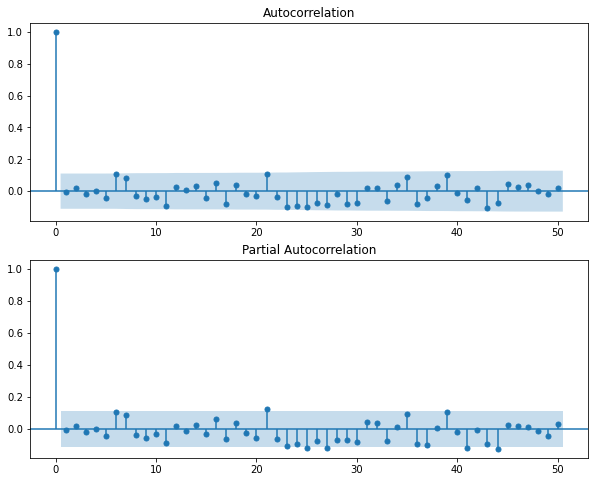

In [36]:
residuos = resultado_model_week.resid
fig,ax = pyplot.subplots(2,1,figsize=(10,8))
fig = plot_acf(residuos, lags=50, ax=ax[0])
fig = plot_pacf(residuos, lags=50, ax=ax[1])
pyplot.show()

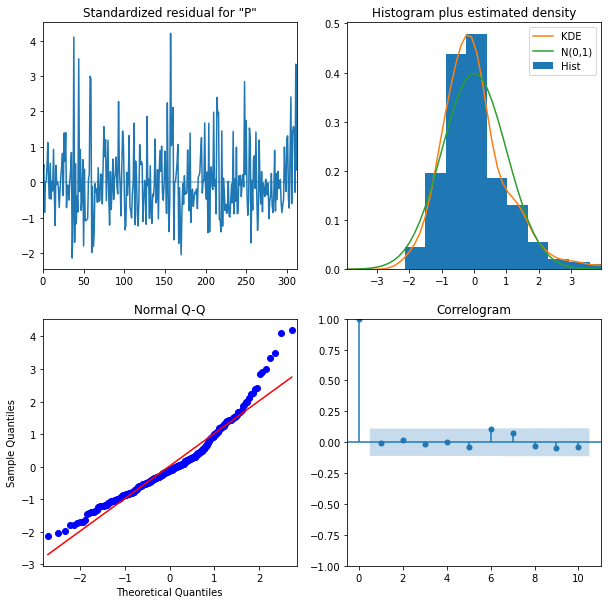

In [35]:
resultado_model_week.plot_diagnostics(figsize=(10,10))
pyplot.show()

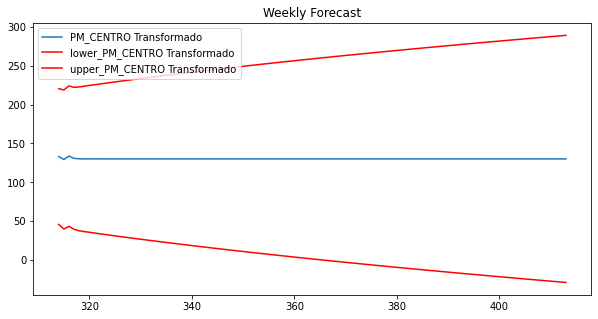

In [56]:
prediccion = resultado_model_week.get_forecast(100)
prediccion_model = pd.DataFrame(prediccion.predicted_mean)
aux = prediccion.conf_int()
prediccion_model = pd.merge(prediccion_model,aux,left_index=True,right_index=True)
prediccion_model.columns = ['PM_CENTRO_final', 'lower_PM_CENTRO', 'upper_PM_CENTRO']
pyplot.figure(figsize=(10,5))
pyplot.title("Weekly Forecast")
pyplot.plot('PM_CENTRO_final', data=prediccion_model, marker='', label='PM_CENTRO Transformado')
pyplot.plot('lower_PM_CENTRO', data=prediccion_model, marker='', color='red' , label='lower_PM_CENTRO Transformado')
pyplot.plot('upper_PM_CENTRO', data=prediccion_model, marker='', color='red' , label='upper_PM_CENTRO Transformado')
pyplot.legend()
pyplot.show()

Serie completa semanal

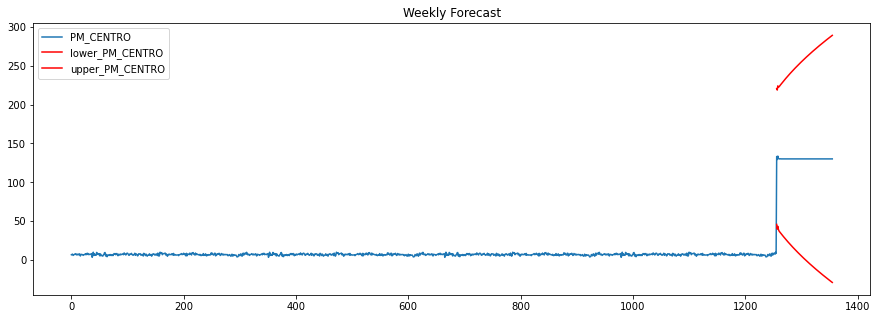

In [60]:
ts_week_t_pred = pd.DataFrame(ts_week_t)
ts_week_t_pred.columns = ['PM_CENTRO_final']
ts_week_t_pred.reset_index(drop=True, inplace=True)
prediccion_model = ts_week_t_pred.append(prediccion_model)
prediccion_model.reset_index(drop=True, inplace=True)


pyplot.figure(figsize=(15,5))
pyplot.title("Weekly Forecast")
pyplot.plot('PM_CENTRO_final', data=prediccion_model, marker='', label='PM_CENTRO')
pyplot.plot('lower_PM_CENTRO', data=prediccion_model, marker='', color='red' , label='lower_PM_CENTRO')
pyplot.plot('upper_PM_CENTRO', data=prediccion_model, marker='', color='red' , label='upper_PM_CENTRO')
pyplot.legend()
pyplot.show()

##### Inclusión de covariables temporales 

In [68]:
ts_week_df=df_week.copy()
ts_week_df=ts_week_df.iloc[:,1:]
ts_week_df


,PM_CENTRO_final,DEW_POINT,HUMIDITY,TEMPERATURE,WIND_SPEED,PRECIPITAITON,COMMULATIVE_PRECIPITATION
0,74.119048,-19.976190,50.678571,-1.862217,32.778571,0.0,0.0
1,88.250000,-18.083333,49.750000,0.157689,43.464464,0.0,0.0
2,106.773810,-14.202381,46.404762,5.017174,38.843810,0.0,0.0
3,50.202381,-17.744048,29.684524,7.002927,51.740417,0.0,0.0
4,76.416667,-14.017857,52.934524,3.836456,10.406071,0.0,0.0
...,...,...,...,...,...,...,...
309,160.470238,-7.706587,59.700599,7.981152,57.305150,0.0,0.0
310,172.720238,-3.577381,74.410714,8.403201,5.003631,0.0,0.0
311,98.160714,-9.684524,55.404762,7.080991,77.864940,1.2,0.7
312,254.404762,-6.523810,76.750000,5.539227,4.200238,0.0,0.0


In [72]:
ts_week_df['DEW_POINT']= ts_week_df['DEW_POINT'].fillna(0)
ts_week_df['HUMIDITY']= ts_week_df['HUMIDITY'].fillna(0)
ts_week_df['TEMPERATURE']= ts_week_df['TEMPERATURE'].fillna(0)
ts_week_df['WIND_SPEED']= ts_week_df['WIND_SPEED'].fillna(0)
ts_week_df['PRECIPITAITON']= ts_week_df['PRECIPITAITON'].fillna(0)
ts_week_df['COMMULATIVE_PRECIPITATION']= ts_week_df['COMMULATIVE_PRECIPITATION'].fillna(0)

##### Ajuste del modelo ARIMA con covariables 

In [73]:
ts_week_df['PM_CENTRO_final_t'] , lambda_t = yeojohnson(ts_week_df.PM_CENTRO_final)
print(lambda_t)
modelo_week = SARIMAX(ts_week_df['PM_CENTRO_final'], order=(1,1,1),seasonal_order=(1,0,0,4)
                       ,exog=ts_week_df[['DEW_POINT'
                                        ,'HUMIDITY'
                                        ,'TEMPERATURE'
                                        ,'WIND_SPEED'
                                        ,'PRECIPITAITON'
                                        ,'COMMULATIVE_PRECIPITATION']])
resultado_modelo_week = modelo_week.fit()
print(resultado_modelo_week.summary())

0.19092905859746923
                                     SARIMAX Results                                      
Dep. Variable:                    PM_CENTRO_final   No. Observations:                  314
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 4)   Log Likelihood               -1593.949
Date:                            Wed, 12 May 2021   AIC                           3207.897
Time:                                    08:52:23   BIC                           3245.359
Sample:                                         0   HQIC                          3222.868
                                            - 314                                         
Covariance Type:                              opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
DEW_POINT                    10.1030      1.940      5.207      

Se analizan residuos para conocer la bondad del modelo.

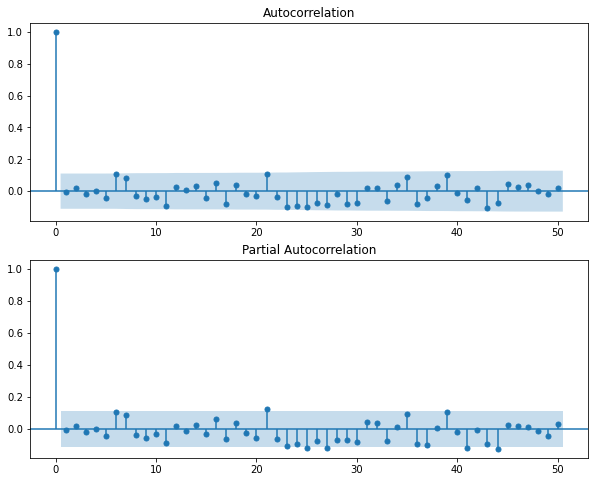

In [74]:
residuos = resultado_modelo_diario.resid
fig,ax = pyplot.subplots(2,1,figsize=(10,8))
fig = plot_acf(residuos, lags=50, ax=ax[0])
fig = plot_pacf(residuos, lags=50, ax=ax[1])
pyplot.show()

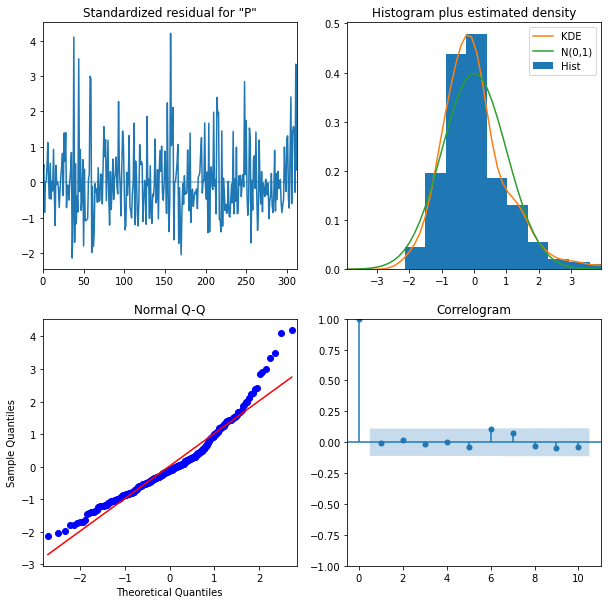

In [75]:
resultado_modelo_diario.plot_diagnostics(figsize=(10,10))
pyplot.show()